# Scrape the Data From Yahoo Finance

In [1]:
import yfinance as yf
import pandas as pd

def scrape_yahoo_finance_data(ticker, start_date, end_date):
    # Download historical data
    data = yf.download(ticker, start=start_date, end=end_date)

    # Print the first few rows of the DataFrame
    print(data.head())

    # Save the data to a CSV file (optional)
    data.to_csv(f"{ticker}_historical_data.csv")

# Example usage
ticker_symbol = "AAPL"  # Apple Inc.
start_date = "2020-01-01"
end_date = "2023-01-01"

scrape_yahoo_finance_data(ticker_symbol, start_date, end_date)


[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  73.152664  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.441444  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  73.018677  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.675270  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.844353  132079200


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pylab
import numpy as np
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt

sns.set()

# import Dataset

In [3]:
df = pd.read_csv("/content/AAPL_historical_data.csv")

In [4]:
df.shape

(756, 7)

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152664,135480400
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441444,146322800
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018677,118387200
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675270,108872000
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.844353,132079200


In [6]:
dfcopy = df.copy()

In [7]:
dfcopy = dfcopy.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])

In [8]:
dfcopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    756 non-null    object 
 1   Close   756 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.9+ KB


In [9]:
dfcopy["Date"] = pd.to_datetime(dfcopy["Date"], dayfirst=True)

In [10]:
dfcopy.set_index('Date', inplace=True)
dfcopy.head()

,Close
Date,
2020-01-02,75.087502
2020-01-03,74.357498
2020-01-06,74.949997
2020-01-07,74.597504
2020-01-08,75.797501


In [11]:
dfcopy = dfcopy.sort_index()
dfcopy.head()

,Close
Date,
2020-01-02,75.087502
2020-01-03,74.357498
2020-01-06,74.949997
2020-01-07,74.597504
2020-01-08,75.797501


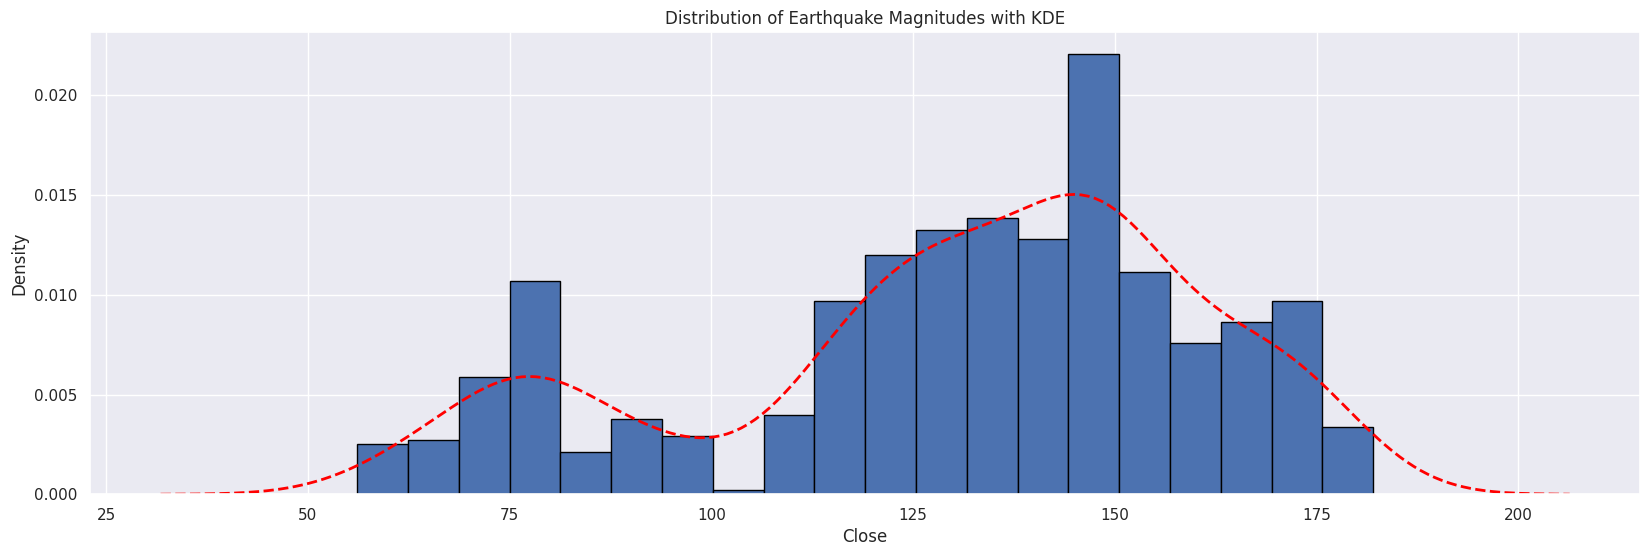

In [12]:
plt.figure(figsize=(20, 6))

plt.hist(dfcopy['Close'], bins=20, edgecolor='black', density=True)

# KDE line
sns.kdeplot(dfcopy['Close'], color='red', linestyle='dashed', linewidth=2)

plt.title('Distribution of Earthquake Magnitudes with KDE')
plt.xlabel('Close')
plt.ylabel('Density')
plt.show()

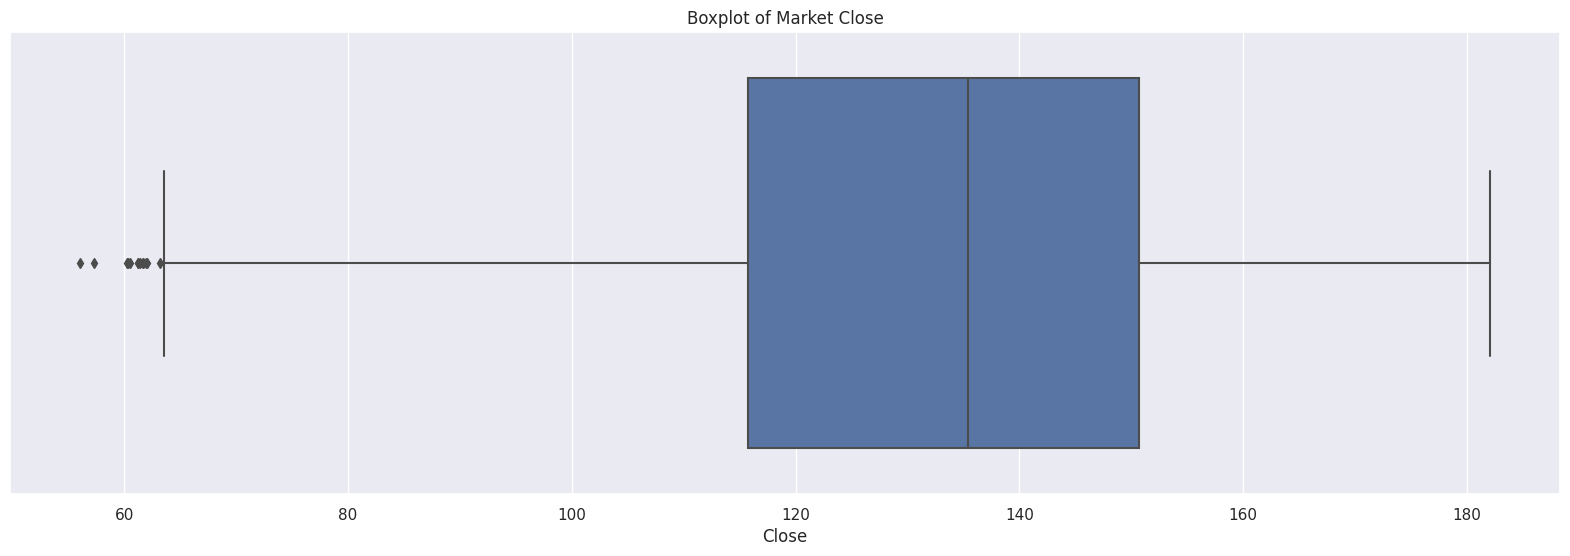

In [13]:
plt.figure(figsize=(20, 6))
sns.boxplot(x=dfcopy['Close'])
plt.title('Boxplot of Market Close')
plt.xlabel('Close')
plt.show()

In [14]:
import plotly.express as px

fig = px.line(dfcopy, x=dfcopy.index, y='Close', markers=True, title='Trend of Close over Time')
fig.update_layout(xaxis_title='Date', yaxis_title='Close', template='plotly_white')

# Show the interactive plot
fig.show()

# Time Series Analysis

### Finding Stationarity

In [15]:
sts.adfuller(dfcopy.Close)

(-1.8953789647960468,
 0.3342381045901881,
 1,
 754,
 {'1%': -3.439052522969989,
  '5%': -2.8653808299915013,
  '10%': -2.5688152592363274},
 3609.599872542912)

In summary, based on the provided results, we may not have enough evidence to reject the null hypothesis that the time series is non-stationary.

In [16]:
dfcopy['Close_diff'] = dfcopy['Close'].diff()

In [17]:
dfcopy.dropna(inplace=True)

sts.adfuller(dfcopy.Close_diff)

(-29.171003879088023,
 0.0,
 0,
 754,
 {'1%': -3.439052522969989,
  '5%': -2.8653808299915013,
  '10%': -2.5688152592363274},
 3607.263632472637)

 based on the results of the ADF test, it appears that differencing has successfully made our time series stationary.

In [18]:
dfcopy.isna().sum()

Close         0
Close_diff    0
dtype: int64

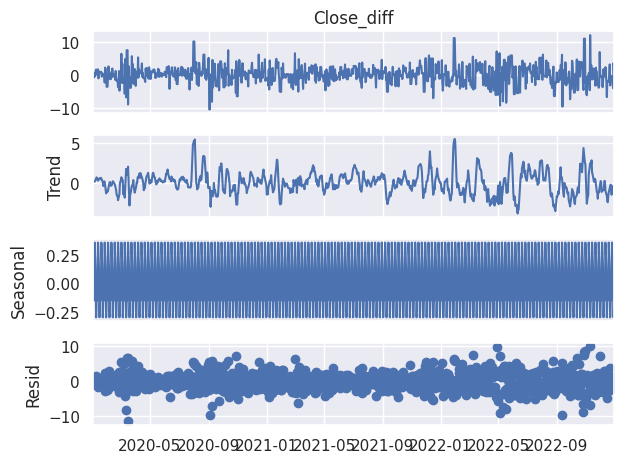

In [19]:
df_daily = dfcopy.asfreq('D')
df_daily['Close_diff'].fillna(method='ffill', inplace=True)  # Forward fill

s_dec_additive = seasonal_decompose(df_daily['Close_diff'], model='additive')
s_dec_additive.plot()
plt.show()

### AutoCorrelation Function

Text(0.5, 1.0, 'AutoCorrelation of Close')

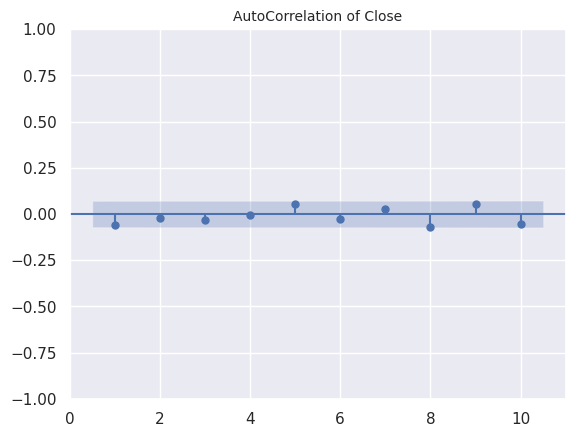

In [20]:
sgt.plot_acf(dfcopy.Close_diff, lags=10, zero=False)
plt.title("AutoCorrelation of Close", size=10)

### Partial Autocorrelation

Text(0.5, 1.0, 'Partial AutoCorrelation of Close')

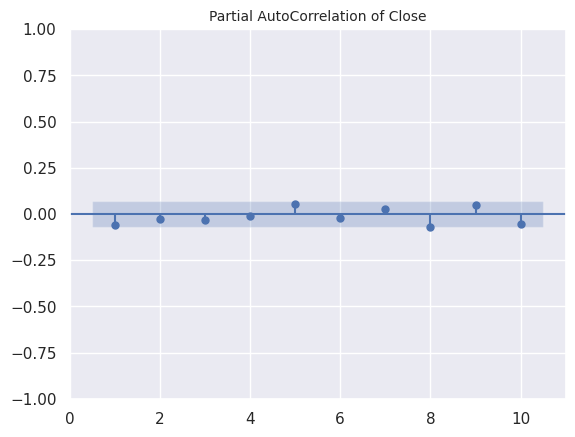

In [21]:
sgt.plot_pacf(dfcopy.Close_diff, lags=10, zero=False)
plt.title("Partial AutoCorrelation of Close", size=10)

# Splitting Data

In [22]:
size = int(len(dfcopy)*0.8)
train_df = dfcopy.iloc[:size]
test_df = dfcopy.iloc[size:]

In [23]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = (50,1,3)
model = ARIMA(train_df['Close_diff'], order=(p, d, q))
results = model.fit()
results.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using z

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Close_diff   No. Observations:                  604
Model:                ARIMA(50, 1, 3)   Log Likelihood               -1419.542
Date:                Thu, 23 Nov 2023   AIC                           2947.084
Time:                        04:52:44   BIC                           3184.788
Sample:                             0   HQIC                          3039.597
                                - 604                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4519      0.845     -1.718      0.086      -3.108       0.204
ar.L2         -0.6551      0.691     -0.948      0.343      -2.010       0.699
ar.L3         -0.0939      0.096     -0.977      0.328      -0.282       0.094
ar.L4         -0.0359      0.109     -0.329      0.742      -0.249       0.178
ar.L5          0.0398      0.089      0.449      0.653      -0.134       0.213
ar.L6          0.0050      0.089      0.056      0.955      -0.170       0.180
ar.L7          0.0198      0.089      0.221      0.825      -0.156       0.195
ar.L8          0.0146      0.090      0.162      0.871      -0.162       0.191
ar.L9         -0.0096      0.090     -0.107      0.915      -0.187       0.167
ar.L10         0.0027      0.089      0.031      0.975      -0.171       0.177
ar.L11         0.0603      0.088      0.686      0.493      -0.112       0.233
ar.L12         0.0758      0.097      0.779      0.436      -0.115       0.266
ar.L13         0.0395      0.096      0.413      0.680      -0.148       0.227
ar.L14         0.0395      0.087      0.453      0.650      -0.131       0.211
ar.L15         0.0087      0.090      0.097      0.923      -0.168       0.186
ar.L16        -0.0439      0.086     -0.509      0.611      -0.213       0.125
ar.L17        -0.0806      0.097     -0.830      0.407      -0.271       0.110
ar.L18         0.0070      0.104      0.067      0.946      -0.196       0.210
ar.L19         0.1046      0.097      1.074      0.283      -0.086       0.296
ar.L20        -0.0166      0.126     -0.132      0.895      -0.263       0.230
ar.L21        -0.1004      0.115     -0.872      0.383      -0.326       0.125
ar.L22        -0.0522      0.100     -0.520      0.603      -0.249       0.145
ar.L23        -0.0430      0.089     -0.481      0.631      -0.218       0.132
ar.L24        -0.0451      0.095     -0.476      0.634      -0.231       0.141
ar.L25        -0.0364      0.086     -0.425      0.671      -0.204       0.132
ar.L26        -0.0826      0.084     -0.984      0.325      -0.247       0.082
ar.L27        -0.0389      0.098     -0.396      0.692      -0.232       0.154
ar.L28        -0.0066      0.091     -0.072      0.943      -0.186       0.172
ar.L29        -0.0637      0.090     -0.708      0.479      -0.240       0.113
ar.L30        -0.0532      0.113     -0.473      0.636      -0.274       0.167
ar.L31        -0.0160      0.090     -0.177      0.860      -0.193       0.161
ar.L32        -0.0052      0.088     -0.059      0.953      -0.179       0.168
ar.L33         0.0322      0.089      0.360      0.719      -0.143       0.208
ar.L34         0.0686      0.091      0.750      0.453      -0.111       0.248
ar.L35         0.0698      0.089      0.785      0.432      -0.104       0.244
ar.L36         0.0552      0.090      0.611      0.541      -0.122       0.232
ar.L37         0.0435      0.091      0.479      0.632      -0.134       0.221
ar.L38         0.0812      0.087      0.929      0.353      -0.090       0.253
ar

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



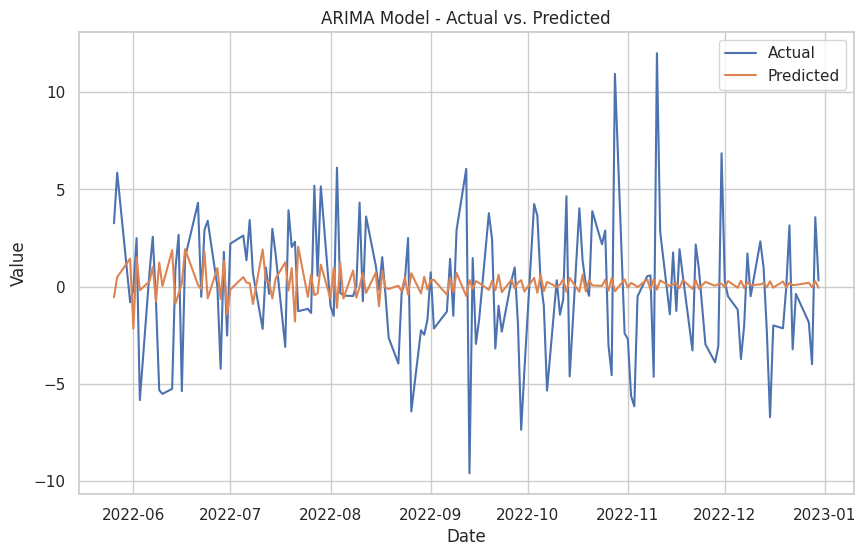

In [24]:
forecast_values = results.forecast(steps=len(test_df))

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Date': test_df.index,
    'Actual': test_df['Close_diff'].values,
    'Predicted': forecast_values
})

# Melt the DataFrame for easier plotting with seaborn
melted_df = pd.melt(results_df, id_vars='Date', var_name='Type', value_name='Value')

# Plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Value', hue='Type', data=melted_df)
plt.title('ARIMA Model - Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [25]:
import plotly.graph_objects as go

# Plot training data
trace_train = go.Scatter(x=train_df.index, y=train_df['Close_diff'], mode='lines', name='Training Data')

# Plot testing data
trace_test = go.Scatter(x=test_df.index, y=test_df['Close_diff'], mode='lines', name='Testing Data')

# Plot forecast
forecast_steps = 100  # Adjust this based on your needs
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=test_df.index[-1], periods=forecast_steps + 1, freq=test_df.index.freq)
trace_forecast = go.Scatter(x=forecast_index[1:], y=forecast.predicted_mean.values, mode='lines', name='Forecast')

# Create layout
layout = go.Layout(
    title='ARIMA Forecasting',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Close'),
    showlegend=True
)

# Create figure
fig = go.Figure(data=[trace_train, trace_test, trace_forecast], layout=layout)

# Show figure
fig.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



# SARIMA

In [75]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(train_df['Close_diff'], order=(3,1,0), seasonal_order=(3,0,3,12))
model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [76]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                 Close_diff   No. Observations:                  604
Model:             SARIMAX(3, 1, 0)x(3, 0, [1, 2, 3], 12)   Log Likelihood               -1507.597
Date:                                    Thu, 23 Nov 2023   AIC                           3035.194
Time:                                            06:52:11   BIC                           3079.213
Sample:                                                 0   HQIC                          3052.325
                                                    - 604                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8130      0.034    -23.802      0.000      -0.880      -0.746
ar.L2         -0.5400      0.043    -12.416      0.000      -0.625      -0.455
ar.L3         -0.3042      0.035     -8.784      0.000      -0.372      -0.236
ar.S.L12      -0.7940      0.200     -3.975      0.000      -1.185      -0.403
ar.S.L24       0.7605      0.211      3.608      0.000       0.347       1.174
ar.S.L36       0.8608      0.176      4.893      0.000       0.516       1.206
ma.S.L12       0.8446      0.207      4.077      0.000       0.439       1.251
ma.S.L24      -0.7302      0.230     -3.171      0.002      -1.181      -0.279
ma.S.L36      -0.8615      0.179     -4.809      0.000      -1.213      -0.510
sigma2         8.7973      0.423     20.780      0.000       7.968       9.627
===================================================================================
Ljung-Box (L1) (Q):                   2.64   Jarque-Bera (JB):                49.52
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                             0.22
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
forecast_values

,ds,yhat
604,2022-05-26,-0.553603
605,2022-05-27,-0.319052
609,2022-05-31,0.297265
610,2022-06-01,0.082551
611,2022-06-02,-0.276649
...,...,...
748,2022-10-17,0.310864
749,2022-10-18,0.154972
750,2022-10-19,-0.133563
751,2022-10-20,-0.560792


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



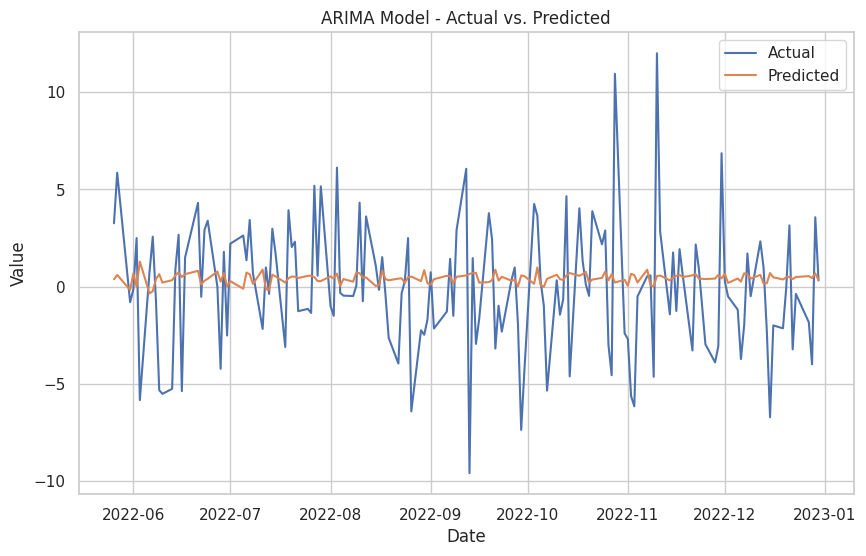

In [28]:
forecast_values = model.forecast(steps=len(test_df))

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Date': test_df.index,
    'Actual': test_df['Close_diff'].values,
    'Predicted': forecast_values
})

# Melt the DataFrame for easier plotting with seaborn
melted_df = pd.melt(results_df, id_vars='Date', var_name='Type', value_name='Value')

# Plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Value', hue='Type', data=melted_df)
plt.title('ARIMA Model - Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [27]:
import plotly.graph_objects as go

# Plot training data
trace_train = go.Scatter(x=train_df.index, y=train_df['Close_diff'], mode='lines', name='Training Data')

# Plot testing data
trace_test = go.Scatter(x=test_df.index, y=test_df['Close_diff'], mode='lines', name='Testing Data')

# Forecast
forecast_steps = 100  # Adjust this based on your needs
forecast = model.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=test_df.index[-1], periods=forecast_steps + 1, freq=test_df.index.freq)
trace_forecast_sarima = go.Scatter(x=forecast_index[1:], y=forecast.predicted_mean.values, mode='lines', name='SARIMA Forecast')

# Create layout
layout = go.Layout(
    title='SARIMA Forecasting',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Depth'),
    showlegend=True
)

# Create figure
fig = go.Figure(data=[trace_train, trace_test, trace_forecast_sarima], layout=layout)

# Show figure
fig.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



# FBProphet

In [64]:
train_df.head()

,index,Date,Close_diff
0,0,2020-01-03,-0.730003
1,1,2020-01-06,0.592499
2,2,2020-01-07,-0.352493
3,3,2020-01-08,1.199997
4,4,2020-01-09,1.610001


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8qestl_y/wtmdiknk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8qestl_y/7a19v3cf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98550', 'data', 'file=/tmp/tmp8qestl_y/wtmdiknk.json', 'init=/tmp/tmp8qestl_y/7a19v3cf.json', 'output', 'file=/tmp/tmp8qestl_y/prophet_modela3g4hamd/prophet_model-20231123065843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:58:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:58:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


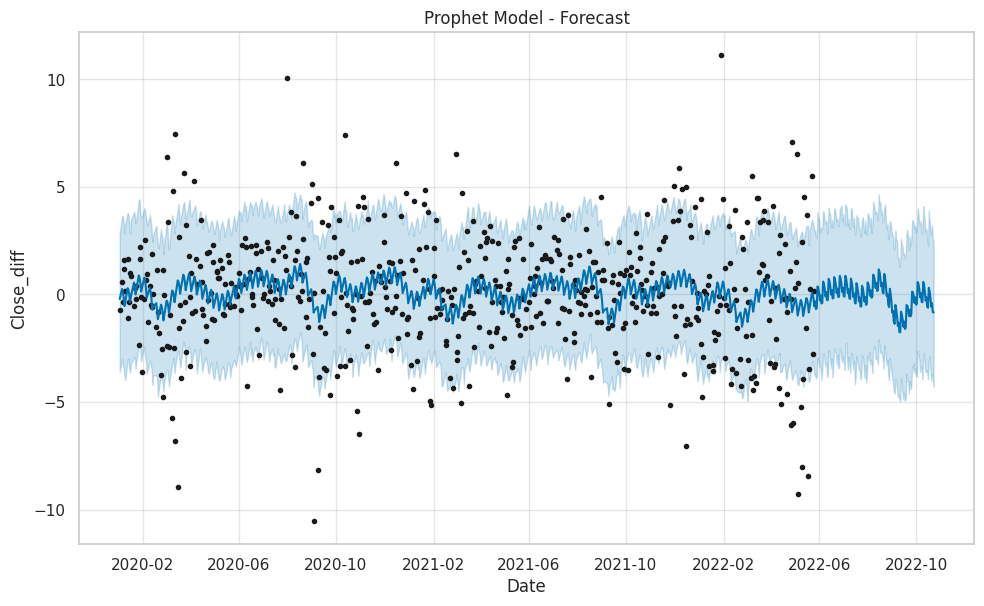

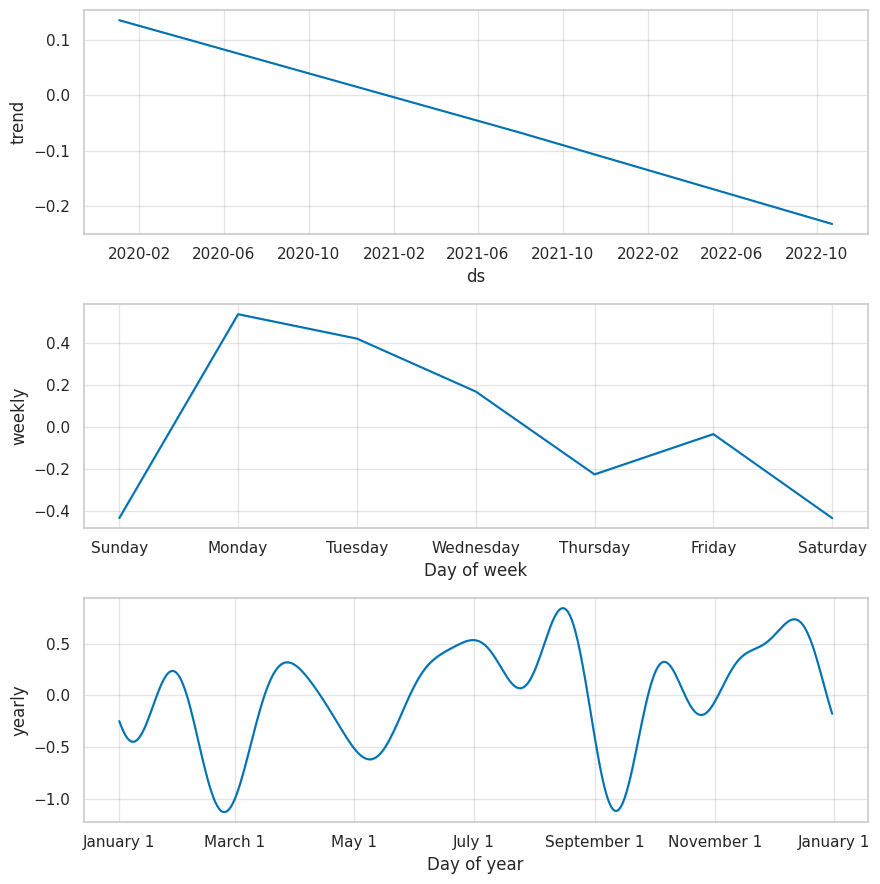

In [78]:
from prophet import Prophet

# Prepare the training data
train_data = train_df[['Date', 'Close_diff']]
train_data.columns = ['ds', 'y']

# Create and fit the Prophet model
model = Prophet()
model.fit(train_data)

# Make future dataframe for forecasting
future = model.make_future_dataframe(periods=len(test_df), freq='D')

# Forecast
forecast = model.predict(future)

# Plot the results
fig = model.plot(forecast)
plt.title('Prophet Model - Forecast')
plt.xlabel('Date')
plt.ylabel('Close_diff')
plt.show()

# Plot the components of the forecast
fig_components = model.plot_components(forecast)
plt.show()


In [66]:
test_df.head()

,Date,Close_diff
index,,
0,2022-05-26,3.259995
1,2022-05-27,5.860001
2,2022-05-31,-0.800003
3,2022-06-01,-0.129990
4,2022-06-02,2.500000


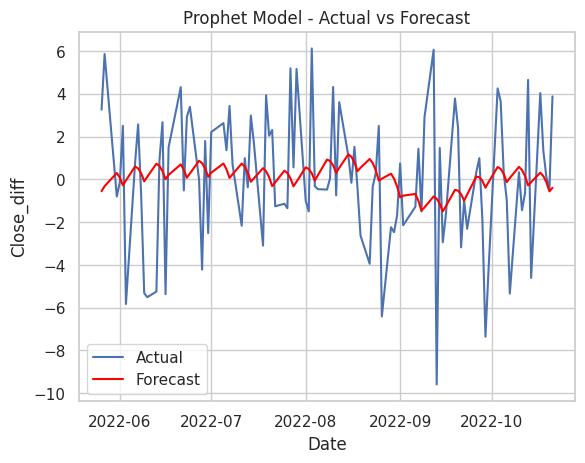

In [79]:


# Assuming 'ds' is the column containing the datetime information
test_data = test_df[['Date']]

# Make future dataframe for forecasting
future = model.make_future_dataframe(periods=len(test_data))

# Forecast
forecast = model.predict(future)

# Extracting relevant columns from the forecast
forecast_values = forecast[['ds', 'yhat']]

# If you have specified a daily frequency, you may want to filter the forecast for the test period
forecast_values = forecast_values[forecast_values['ds'].isin(test_data['Date'])]

# Merging forecast with the original test_df
merged_df = pd.merge(test_df, forecast_values, left_on='Date', right_on='ds')

# Plotting the forecast along with actual values
plt.plot(merged_df['Date'], merged_df['Close_diff'], label='Actual')
plt.plot(merged_df['Date'], merged_df['yhat'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Close_diff')
plt.title('Prophet Model - Actual vs Forecast')
plt.legend()
plt.show()
